# 🪙 Bitcoin Price Prediction with LSTM

## Регресійна модель для прогнозування ціни Bitcoin

**Задача:** Використовуючи 6000 хвилин історичних даних, прогнозувати ціну на наступні 180 хвилин.

**Технології:**
- PyTorch з MPS (Metal Performance Shaders) для Apple Silicon M4
- LSTM Encoder-Decoder архітектура
- Технічні індикатори як додаткові фічі

**Оптимізація для MacBook Air M4 16GB:**
- Використання MPS backend замість CUDA
- Оптимізовані batch sizes
- Ефективне використання пам'яті

## 1. Імпорт бібліотек та налаштування середовища

In [1]:
# Основні бібліотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Налаштування відображення
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Перевірка доступності MPS (Metal Performance Shaders) для Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Apple Silicon GPU) доступний!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ CUDA GPU доступний!")
else:
    device = torch.device("cpu")
    print("⚠️ GPU недоступний, використовуємо CPU")

print(f"PyTorch версія: {torch.__version__}")
print(f"Використовуємо device: {device}")

✅ MPS (Apple Silicon GPU) доступний!
PyTorch версія: 2.9.1
Використовуємо device: mps


## 2. Завантаження та первинний аналіз даних (Kaggle Dataset)

In [2]:
# Завантаження Kaggle датасету
df = pd.read_csv('btcusd_1-min_data.csv')

print("=" * 60)
print("📊 ЗАГАЛЬНА ІНФОРМАЦІЯ ПРО ДАТАСЕТ")
print("=" * 60)
print(f"\nРозмір датасету: {df.shape[0]:,} рядків, {df.shape[1]} колонок")
print(f"Пам'ять: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📋 Структура даних:")
print(df.info())

print("\n📈 Статистичний опис:")
df.describe()

📊 ЗАГАЛЬНА ІНФОРМАЦІЯ ПРО ДАТАСЕТ

Розмір датасету: 7,335,037 рядків, 6 колонок
Пам'ять: 335.77 MB

📋 Структура даних:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7335037 entries, 0 to 7335036
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 335.8 MB
None

📈 Статистичний опис:


,Timestamp,Open,High,Low,Close,Volume
count,7335037.0000,7335037.0000,7335037.0000,7335037.0000,7335037.0000,7335037.0000
mean,1545466859.1642,21413.3349,21421.0221,21405.4451,21413.3428,5.1217
std,127052674.6292,30074.9244,30083.1386,30066.5955,30074.9288,22.0430
min,1325412060.0000,3.8000,3.8000,3.8000,3.8000,0.0000
25%,1435437600.0000,444.0000,444.2000,443.8900,444.0000,0.0198
50%,1545463140.0000,7308.1500,7312.5000,7303.7100,7308.1000,0.4493
75%,1655488680.0000,31182.2700,31204.0000,31161.0000,31183.6100,2.8948
max,1765583820.0000,126202.0000,126272.0000,126158.0000,126202.0000,5853.8522


In [3]:
# Конвертація timestamp та аналіз часового діапазону
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')

print("=" * 60)
print("📅 ЧАСОВИЙ ДІАПАЗОН ДАНИХ")
print("=" * 60)
print(f"Початок: {df['datetime'].min()}")
print(f"Кінець: {df['datetime'].max()}")
print(f"Тривалість: {(df['datetime'].max() - df['datetime'].min()).days} днів")

# Аналіз пропущених значень
print("\n" + "=" * 60)
print("🔍 АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ")
print("=" * 60)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Пропущено': missing, 'Відсоток %': missing_pct})
print(missing_df)

# Перевірка на пропуски у часових мітках
df_sorted = df.sort_values('Timestamp')
time_diff = df_sorted['Timestamp'].diff()
gaps = time_diff[time_diff > 60]  # Пропуски більше 1 хвилини
print(f"\n⏱️ Кількість часових пропусків (>1 хв): {len(gaps):,}")
if len(gaps) > 0:
    print(f"Найбільший пропуск: {gaps.max() / 60:.0f} хвилин ({gaps.max() / 3600:.1f} годин)")

📅 ЧАСОВИЙ ДІАПАЗОН ДАНИХ
Початок: 2012-01-01 10:01:00
Кінець: 2025-12-12 23:57:00
Тривалість: 5094 днів

🔍 АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ
           Пропущено  Відсоток %
Timestamp          0      0.0000
Open               0      0.0000
High               0      0.0000
Low                0      0.0000
Close              0      0.0000
Volume             0      0.0000
datetime           0      0.0000

⏱️ Кількість часових пропусків (>1 хв): 1
Найбільший пропуск: 1161 хвилин (19.4 годин)


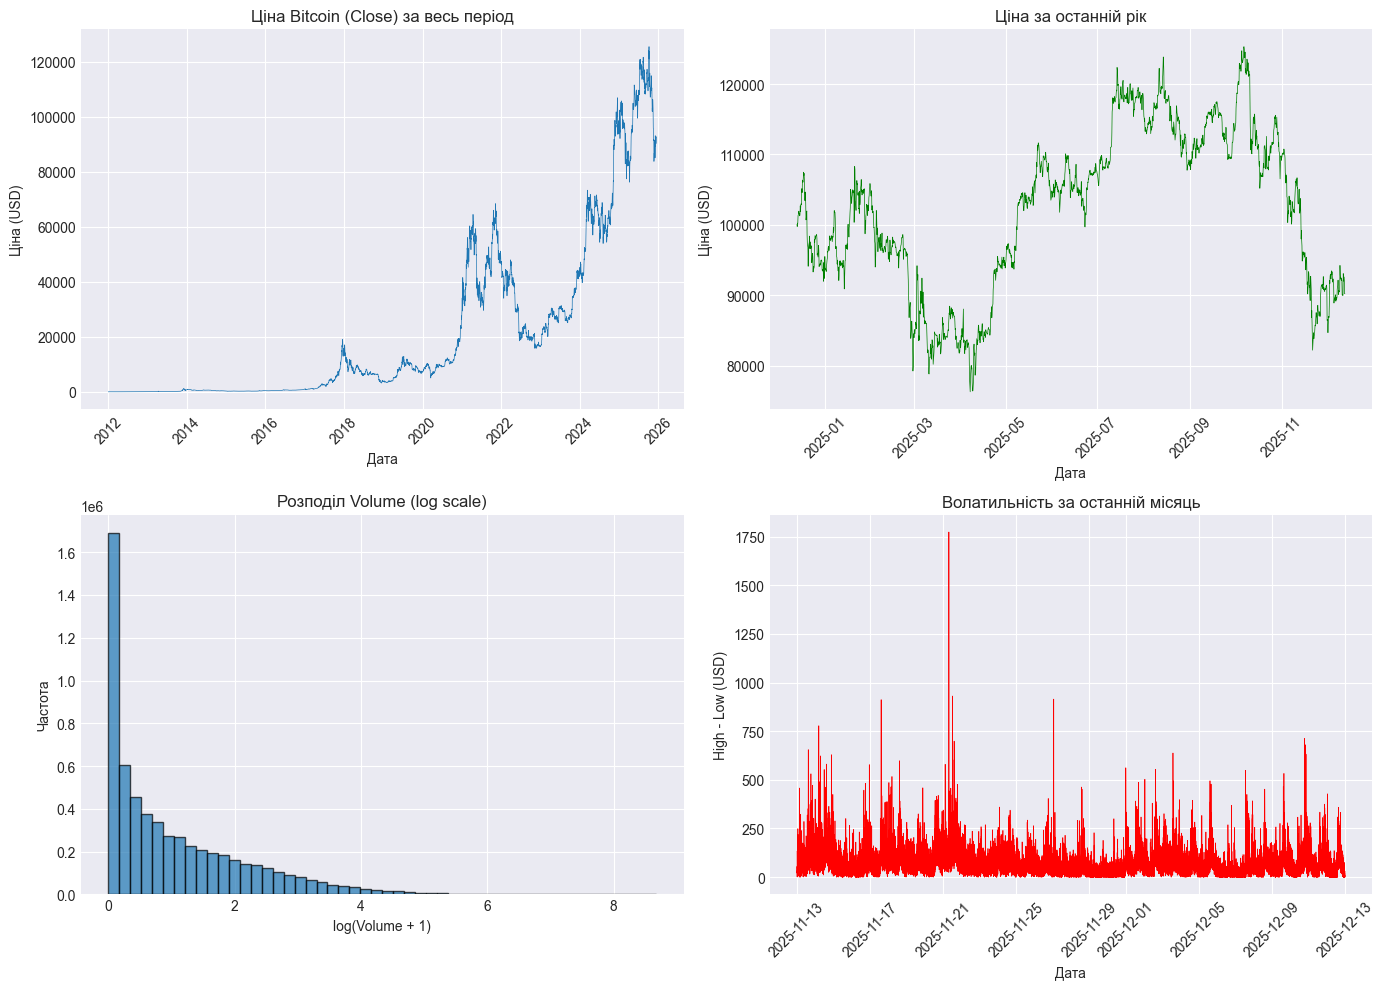

In [4]:
# Візуалізація даних
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Графік ціни за весь період
ax1 = axes[0, 0]
sample_idx = np.linspace(0, len(df)-1, 5000, dtype=int)  # Семплінг для швидкості
ax1.plot(df.iloc[sample_idx]['datetime'], df.iloc[sample_idx]['Close'], linewidth=0.5)
ax1.set_title('Ціна Bitcoin (Close) за весь період', fontsize=12)
ax1.set_xlabel('Дата')
ax1.set_ylabel('Ціна (USD)')
ax1.tick_params(axis='x', rotation=45)

# 2. Останній рік детальніше
ax2 = axes[0, 1]
last_year = df[df['datetime'] >= df['datetime'].max() - pd.Timedelta(days=365)]
sample_idx2 = np.linspace(0, len(last_year)-1, 2000, dtype=int)
ax2.plot(last_year.iloc[sample_idx2]['datetime'], last_year.iloc[sample_idx2]['Close'], linewidth=0.5, color='green')
ax2.set_title('Ціна за останній рік', fontsize=12)
ax2.set_xlabel('Дата')
ax2.set_ylabel('Ціна (USD)')
ax2.tick_params(axis='x', rotation=45)

# 3. Розподіл Volume
ax3 = axes[1, 0]
volume_nonzero = df[df['Volume'] > 0]['Volume']
ax3.hist(np.log1p(volume_nonzero), bins=50, edgecolor='black', alpha=0.7)
ax3.set_title('Розподіл Volume (log scale)', fontsize=12)
ax3.set_xlabel('log(Volume + 1)')
ax3.set_ylabel('Частота')

# 4. Волатильність (High - Low)
ax4 = axes[1, 1]
df['volatility'] = df['High'] - df['Low']
recent = df[df['datetime'] >= df['datetime'].max() - pd.Timedelta(days=30)]
ax4.plot(recent['datetime'], recent['volatility'], linewidth=0.5, color='red')
ax4.set_title('Волатильність за останній місяць', fontsize=12)
ax4.set_xlabel('Дата')
ax4.set_ylabel('High - Low (USD)')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Порівняння Kaggle та Binance датасетів

**Висновок щодо джерел даних:**

| Критерій | Kaggle (Bitstamp) | Binance |
|----------|-------------------|---------|
| Часовий діапазон | 2012 - сьогодні | 2017 - сьогодні |
| Гранулярність | 1 хвилина | 1 хвилина |
| Якість даних | Добра, є пропуски | Відмінна |
| Ліквідність | Середня | Висока |
| Обсяг торгів | Менший | Найбільший |

**Рекомендація:** 
- Kaggle датасет достатній для навчання, оскільки має довшу історію
- Для production краще використовувати Binance через вищу ліквідність
- Ми продовжимо з Kaggle датасетом, оскільки він вже завантажений і має достатню якість

## 4. Очищення та підготовка даних

In [5]:
# Очищення даних
print("=" * 60)
print("🧹 ОЧИЩЕННЯ ДАНИХ")
print("=" * 60)

# 1. Сортування за часом
df = df.sort_values('datetime').reset_index(drop=True)

# 2. Видалення дублікатів
initial_len = len(df)
df = df.drop_duplicates(subset=['Timestamp'], keep='first')
print(f"Видалено дублікатів: {initial_len - len(df):,}")

# 3. Використовуємо тільки останні 2 роки (для оптимізації пам'яті та актуальності)
# Це ~1M рядків, що достатньо для тренування
cutoff_date = df['datetime'].max() - pd.Timedelta(days=730)  # 2 роки
df = df[df['datetime'] >= cutoff_date].reset_index(drop=True)
print(f"Залишено рядків (останні 2 роки): {len(df):,}")

# 4. Заповнення пропущених значень методом forward fill
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[col] = df[col].ffill()
    df[col] = df[col].bfill()  # Для початкових значень

# 5. Видалення рядків де всі OHLC = 0
df = df[(df['Close'] > 0) & (df['Open'] > 0)]
print(f"Після видалення нульових цін: {len(df):,}")

# 6. Перевірка результату
print(f"\n📊 Фінальний розмір даних: {len(df):,} рядків")
print(f"Часовий діапазон: {df['datetime'].min()} — {df['datetime'].max()}")
print(f"Пропущених значень: {df[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum().sum()}")

🧹 ОЧИЩЕННЯ ДАНИХ
Видалено дублікатів: 0
Залишено рядків (останні 2 роки): 1,050,041
Після видалення нульових цін: 1,050,041

📊 Фінальний розмір даних: 1,050,041 рядків
Часовий діапазон: 2023-12-13 23:57:00 — 2025-12-12 23:57:00
Пропущених значень: 0


## 5. Feature Engineering: технічні індикатори

Додаємо технічні індикатори, які допоможуть моделі краще розуміти ринкові тренди:
- **SMA/EMA** - ковзні середні для трендів
- **RSI** - індекс відносної сили
- **MACD** - конвергенція/дивергенція ковзних середніх
- **Bollinger Bands** - волатильність
- **ATR** - середній справжній діапазон

In [6]:
def add_technical_indicators(df):
    """Додає технічні індикатори до датафрейму"""
    
    # Ковзні середні (SMA)
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['SMA_60'] = df['Close'].rolling(window=60).mean()
    
    # Експоненційні ковзні середні (EMA)
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()
    
    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    
    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    
    # ATR (Average True Range)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(window=14).mean()
    
    # Volume Moving Average
    df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_ratio'] = df['Volume'] / (df['Volume_MA'] + 1e-10)
    
    # Price changes
    df['price_change'] = df['Close'].pct_change()
    df['price_change_5'] = df['Close'].pct_change(5)
    df['price_change_15'] = df['Close'].pct_change(15)
    
    # Час як фічі (циклічні)
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    return df

# Застосування технічних індикаторів
df = add_technical_indicators(df)

# Видалення рядків з NaN (на початку через rolling)
df = df.dropna().reset_index(drop=True)

print(f"✅ Додано технічні індикатори")
print(f"📊 Фінальний розмір: {len(df):,} рядків, {len(df.columns)} колонок")
print(f"\n📋 Всі фічі:")
print(df.columns.tolist())

✅ Додано технічні індикатори
📊 Фінальний розмір: 1,049,982 рядків, 33 колонок

📋 Всі фічі:
['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'datetime', 'volatility', 'SMA_10', 'SMA_30', 'SMA_60', 'EMA_10', 'EMA_30', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'BB_middle', 'BB_upper', 'BB_lower', 'BB_width', 'ATR', 'Volume_MA', 'Volume_ratio', 'price_change', 'price_change_5', 'price_change_15', 'hour', 'day_of_week', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


## 6. Створення часових вікон (Sliding Window)

Параметри:
- **INPUT_WINDOW = 6000** хвилин (~4.2 дні) - вхідна послідовність
- **OUTPUT_WINDOW = 180** хвилин (3 години) - прогноз
- **STRIDE = 60** хвилин - крок для створення вікон

In [7]:
# Параметри часових вікон
INPUT_WINDOW = 1440   # Вхідна послідовність (хвилин)
OUTPUT_WINDOW = 30   # Прогноз (хвилин)
STRIDE = 60           # Крок між вікнами (хвилин)

# Фічі для моделі (без datetime, Timestamp)
FEATURE_COLUMNS = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_10', 'SMA_30', 'SMA_60', 'EMA_10', 'EMA_30',
    'RSI', 'MACD', 'MACD_signal', 'MACD_hist',
    'BB_width', 'ATR', 'Volume_ratio',
    'price_change', 'price_change_5', 'price_change_15',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
]

# Цільова змінна - тільки Close price
TARGET_COLUMN = 'Close'

print(f"📊 Конфігурація:")
print(f"   Вхідне вікно: {INPUT_WINDOW} хв ({INPUT_WINDOW/60:.1f} год, {INPUT_WINDOW/1440:.1f} днів)")
print(f"   Вихідне вікно: {OUTPUT_WINDOW} хв ({OUTPUT_WINDOW/60:.1f} год)")
print(f"   Крок: {STRIDE} хв")
print(f"   Кількість фіч: {len(FEATURE_COLUMNS)}")

📊 Конфігурація:
   Вхідне вікно: 1440 хв (24.0 год, 1.0 днів)
   Вихідне вікно: 30 хв (0.5 год)
   Крок: 60 хв
   Кількість фіч: 24


## 7. Нормалізація даних та розділення на train/val/test

In [8]:
# Розділення даних (хронологічно!)
# 70% train, 15% validation, 15% test
train_size = int(len(df) * 0.70)
val_size = int(len(df) * 0.15)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

print(f"📊 Розділення даних:")
print(f"   Train: {len(train_df):,} рядків ({train_df['datetime'].min()} — {train_df['datetime'].max()})")
print(f"   Val:   {len(val_df):,} рядків ({val_df['datetime'].min()} — {val_df['datetime'].max()})")
print(f"   Test:  {len(test_df):,} рядків ({test_df['datetime'].min()} — {test_df['datetime'].max()})")

# Нормалізація (fit тільки на train!)
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit на train
feature_scaler.fit(train_df[FEATURE_COLUMNS])
target_scaler.fit(train_df[[TARGET_COLUMN]])

# Transform всіх наборів
train_features = feature_scaler.transform(train_df[FEATURE_COLUMNS])
val_features = feature_scaler.transform(val_df[FEATURE_COLUMNS])
test_features = feature_scaler.transform(test_df[FEATURE_COLUMNS])

train_target = target_scaler.transform(train_df[[TARGET_COLUMN]])
val_target = target_scaler.transform(val_df[[TARGET_COLUMN]])
test_target = target_scaler.transform(test_df[[TARGET_COLUMN]])

print(f"\n✅ Дані нормалізовано (MinMaxScaler)")

📊 Розділення даних:
   Train: 734,987 рядків (2023-12-14 00:56:00 — 2025-05-08 06:02:00)
   Val:   157,497 рядків (2025-05-08 06:03:00 — 2025-08-25 14:59:00)
   Test:  157,498 рядків (2025-08-25 15:00:00 — 2025-12-12 23:57:00)

✅ Дані нормалізовано (MinMaxScaler)


In [9]:
class BitcoinDataset(Dataset):
    """
    PyTorch Dataset для Bitcoin prediction.
    Генерує вікна (X, y) з часових рядів.
    """
    def __init__(self, features, target, input_window, output_window, stride=1):
        self.features = features
        self.target = target
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride
        
        # Розрахунок кількості можливих вікон
        total_window = input_window + output_window
        self.n_samples = (len(features) - total_window) // stride + 1
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        start_idx = idx * self.stride
        
        # Вхідні дані (всі фічі)
        X = self.features[start_idx : start_idx + self.input_window]
        
        # Вихідні дані (тільки target - Close price)
        y = self.target[start_idx + self.input_window : 
                        start_idx + self.input_window + self.output_window]
        
        return (
            torch.FloatTensor(X),
            torch.FloatTensor(y).squeeze(-1)  # (output_window,)
        )

# Створення датасетів
train_dataset = BitcoinDataset(train_features, train_target, INPUT_WINDOW, OUTPUT_WINDOW, STRIDE)
val_dataset = BitcoinDataset(val_features, val_target, INPUT_WINDOW, OUTPUT_WINDOW, STRIDE)
test_dataset = BitcoinDataset(test_features, test_target, INPUT_WINDOW, OUTPUT_WINDOW, STRIDE)

print(f"📊 Розмір датасетів:")
print(f"   Train: {len(train_dataset):,} зразків")
print(f"   Val:   {len(val_dataset):,} зразків")
print(f"   Test:  {len(test_dataset):,} зразків")

# Перевірка форми даних
sample_X, sample_y = train_dataset[0]
print(f"\n📐 Форма даних:")
print(f"   X: {sample_X.shape} (input_window × features)")
print(f"   y: {sample_y.shape} (output_window,)")

📊 Розмір датасетів:
   Train: 12,226 зразків
   Val:   2,601 зразків
   Test:  2,601 зразків

📐 Форма даних:
   X: torch.Size([1440, 24]) (input_window × features)
   y: torch.Size([30]) (output_window,)


## 8. Побудова LSTM моделі

Архітектура моделі:
- **Encoder**: LSTM шари для кодування вхідної послідовності
- **Decoder**: LSTM + Linear для генерації прогнозу
- **Dropout**: Регуляризація для запобігання overfitting

In [10]:
class BitcoinLSTM(nn.Module):
    """
    LSTM модель для прогнозування ціни Bitcoin.
    
    Архітектура:
    - Encoder: Багатошаровий LSTM для кодування вхідної послідовності
    - Decoder: Fully connected шари для генерації прогнозу
    """
    def __init__(self, 
                 input_size,        # Кількість фіч
                 hidden_size=128,   # Розмір прихованого стану LSTM
                 num_layers=2,      # Кількість LSTM шарів
                 output_window=180, # Довжина прогнозу
                 dropout=0.2):      # Dropout rate
        super(BitcoinLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_window = output_window
        
        # Encoder LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Decoder (fully connected layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_window)
        )
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        
        # LSTM encoder
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out shape: (batch_size, seq_len, hidden_size)
        
        # Використовуємо останній hidden state
        last_hidden = hidden[-1]  # (batch_size, hidden_size)
        
        # Decoder
        out = self.dropout(last_hidden)
        out = self.fc(out)  # (batch_size, output_window)
        
        return out

# Створення моделі
model = BitcoinLSTM(
    input_size=len(FEATURE_COLUMNS),
    hidden_size=128,
    num_layers=2,
    output_window=OUTPUT_WINDOW,
    dropout=0.2
)

# Підрахунок параметрів
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("📊 Архітектура моделі:")
print(model)
print(f"\n📈 Параметри:")
print(f"   Загально: {total_params:,}")
print(f"   Тренованих: {trainable_params:,}")

📊 Архітектура моделі:
BitcoinLSTM(
  (lstm): LSTM(24, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=30, bias=True)
  )
)

📈 Параметри:
   Загально: 280,734
   Тренованих: 280,734


## 9. Налаштування для Apple Silicon (MPS)

In [11]:
# Оптимізовані параметри для MacBook Air M4 16GB
BATCH_SIZE = 32       # Оптимально для 16GB RAM
NUM_WORKERS = 0       # MPS працює краще без multiprocessing
PIN_MEMORY = False    # Не потрібно для MPS

# Переміщення моделі на MPS
model = model.to(device)

# Створення DataLoader з оптимізованими параметрами
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"✅ Модель переміщено на {device}")
print(f"📊 Batch size: {BATCH_SIZE}")
print(f"📊 Train batches: {len(train_loader)}")
print(f"📊 Val batches: {len(val_loader)}")
print(f"📊 Test batches: {len(test_loader)}")

✅ Модель переміщено на mps
📊 Batch size: 32
📊 Train batches: 383
📊 Val batches: 82
📊 Test batches: 82


## 10. Тренування моделі

In [12]:
# Гіперпараметри тренування
EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
PATIENCE = 7  # Early stopping patience
GRADIENT_CLIP = 1.0

# Loss та Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def train_epoch(model, loader, criterion, optimizer, device, clip_value=1.0):
    """Тренування однієї епохи"""
    model.train()
    total_loss = 0
    
    for batch_idx, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    """Валідація моделі"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            total_loss += loss.item()
            
    return total_loss / len(loader)

print("✅ Готово до тренування")
print(f"📊 Epochs: {EPOCHS}")
print(f"📊 Learning rate: {LEARNING_RATE}")
print(f"📊 Early stopping patience: {PATIENCE}")

✅ Готово до тренування
📊 Epochs: 30
📊 Learning rate: 0.001
📊 Early stopping patience: 7


In [13]:
# Тренувальний цикл з Early Stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print("🚀 Початок тренування...")
print("=" * 70)

for epoch in range(EPOCHS):
    # Тренування
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, GRADIENT_CLIP)
    train_losses.append(train_loss)
    
    # Валідація
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Логування
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {current_lr:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"          ✅ Новий найкращий результат! Val Loss: {val_loss:.6f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⚠️ Early stopping на епосі {epoch+1} (patience={PATIENCE})")
            break

# Завантаження найкращої моделі
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Завантажено найкращу модель з Val Loss: {best_val_loss:.6f}")

🚀 Початок тренування...
Epoch   1/30 | Train Loss: 0.012896 | Val Loss: 0.003736 | LR: 0.001000
          ✅ Новий найкращий результат! Val Loss: 0.003736
Epoch   2/30 | Train Loss: 0.002748 | Val Loss: 0.007079 | LR: 0.001000
Epoch   3/30 | Train Loss: 0.002197 | Val Loss: 0.008227 | LR: 0.001000
Epoch   4/30 | Train Loss: 0.001757 | Val Loss: 0.009138 | LR: 0.001000
Epoch   5/30 | Train Loss: 0.001567 | Val Loss: 0.006296 | LR: 0.000500
Epoch   6/30 | Train Loss: 0.001289 | Val Loss: 0.004523 | LR: 0.000500
Epoch   7/30 | Train Loss: 0.001194 | Val Loss: 0.002309 | LR: 0.000500
          ✅ Новий найкращий результат! Val Loss: 0.002309
Epoch   8/30 | Train Loss: 0.001109 | Val Loss: 0.008304 | LR: 0.000500
Epoch   9/30 | Train Loss: 0.001096 | Val Loss: 0.004208 | LR: 0.000500
Epoch  10/30 | Train Loss: 0.000990 | Val Loss: 0.016937 | LR: 0.000500
Epoch  11/30 | Train Loss: 0.001077 | Val Loss: 0.003443 | LR: 0.000250
Epoch  12/30 | Train Loss: 0.000926 | Val Loss: 0.002732 | LR: 0.000

### ⚠️ Якщо тренування занадто довге - можна зупинити

Натисни **Interrupt Kernel** (квадратик ⬛ вгорі) щоб зупинити тренування.

Потім запусти наступну комірку для збереження поточної моделі:

In [14]:
# Якщо перервав тренування - завантажуємо найкращу збережену модель
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Використовуємо найкращу модель з Val Loss: {best_val_loss:.6f}")
else:
    print("⚠️ Використовуємо поточний стан моделі")
    
print(f"📊 Протреновано епох: {len(train_losses)}")
print(f"📉 Остання Train Loss: {train_losses[-1]:.6f}")
print(f"📉 Остання Val Loss: {val_losses[-1]:.6f}")

✅ Використовуємо найкращу модель з Val Loss: 0.002004
📊 Протреновано епох: 26
📉 Остання Train Loss: 0.000689
📉 Остання Val Loss: 0.002676


### 🚀 Як прискорити тренування (опціонально)

Якщо хочеш швидше результати, можна змінити параметри перед тренуванням:

```python
# Менше вікно (швидше, але менше контексту)
INPUT_WINDOW = 1440  # 1 день замість 4 днів
OUTPUT_WINDOW = 60   # 1 година замість 3 годин
STRIDE = 120         # Більший крок = менше зразків

# Менша модель
hidden_size=64       # Замість 128
num_layers=1         # Замість 2

# Менше епох
EPOCHS = 20          # Замість 50
```

Або просто **зменши EPOCHS до 15-20** якщо Val Loss вже не покращується.

## 11. Оцінка якості моделі

In [15]:
def evaluate_model(model, loader, device, scaler):
    """Повна оцінка моделі на тестових даних"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            output = model(X)
            
            all_predictions.append(output.cpu().numpy())
            all_targets.append(y.numpy())
    
    # Об'єднання всіх батчів
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    # Зворотне перетворення (denormalization)
    predictions_orig = scaler.inverse_transform(predictions)
    targets_orig = scaler.inverse_transform(targets)
    
    return predictions_orig, targets_orig

# Отримання прогнозів
predictions, actuals = evaluate_model(model, test_loader, device, target_scaler)

print(f"📊 Форма прогнозів: {predictions.shape}")
print(f"📊 Форма реальних значень: {actuals.shape}")

📊 Форма прогнозів: (2601, 30)
📊 Форма реальних значень: (2601, 30)


In [16]:
# Розрахунок метрик
def calculate_metrics(predictions, actuals):
    """Розрахунок всіх метрик якості"""
    # Flatten для загальних метрик
    pred_flat = predictions.flatten()
    actual_flat = actuals.flatten()
    
    metrics = {
        'MSE': mean_squared_error(actual_flat, pred_flat),
        'RMSE': np.sqrt(mean_squared_error(actual_flat, pred_flat)),
        'MAE': mean_absolute_error(actual_flat, pred_flat),
        'R2': r2_score(actual_flat, pred_flat),
        'MAPE': np.mean(np.abs((actual_flat - pred_flat) / (actual_flat + 1e-10))) * 100
    }
    
    return metrics

# Метрики моделі
metrics = calculate_metrics(predictions, actuals)

# ✅ ВИПРАВЛЕНИЙ Baseline: повторюємо ОСТАННЄ значення з вхідного вікна
# Потрібно отримати останні значення з test_features для кожного зразка
print("🔧 Створюємо правильний baseline...")

# Для baseline беремо останню точку з input window кожного зразка
baseline_predictions = []
for i in range(len(test_dataset)):
    # Отримуємо зразок
    X, y = test_dataset[i]
    # Беремо останнє значення Close з вхідної послідовності
    # X shape: (6000, 24), Close це 4-та колонка (індекс 3)
    last_input_price = test_features[i * test_dataset.stride + INPUT_WINDOW - 1, 3:4]  # Close price
    # Denormalize
    last_price = target_scaler.inverse_transform(last_input_price.reshape(1, -1))[0, 0]
    # Повторюємо для всіх 180 хвилин
    baseline_predictions.append(np.full(OUTPUT_WINDOW, last_price))

baseline_predictions = np.array(baseline_predictions)
baseline_metrics = calculate_metrics(baseline_predictions, actuals)

print("=" * 60)
print("📊 МЕТРИКИ ЯКОСТІ МОДЕЛІ")
print("=" * 60)
print(f"\n{'Метрика':<15} {'LSTM Model':>15} {'Baseline (Naive)':>18} {'Improvement':>12}")
print("-" * 65)
for key in metrics:
    model_val = metrics[key]
    baseline_val = baseline_metrics[key]
    if key != 'R2':
        improvement = ((baseline_val - model_val) / (baseline_val + 1e-10) * 100)
        sign = "✅" if improvement > 0 else "❌"
    else:
        improvement = ((model_val - baseline_val) * 100)
        sign = "✅" if improvement > 0 else "❌"
    print(f"{key:<15} {model_val:>15.4f} {baseline_val:>18.4f}  {sign} {improvement:>+8.1f}%")

print("\n" + "=" * 60)
print("📈 ІНТЕРПРЕТАЦІЯ")
print("=" * 60)
print(f"• RMSE: Середня помилка прогнозу ±${metrics['RMSE']:.2f}")
print(f"• MAE: Медіанна помилка ±${metrics['MAE']:.2f}")
print(f"• MAPE: Відносна помилка {metrics['MAPE']:.2f}%")
print(f"• R²: Модель пояснює {metrics['R2']*100:.1f}% варіації")

if metrics['RMSE'] > baseline_metrics['RMSE']:
    print("\n⚠️ УВАГА: Модель працює ГІРШЕ за baseline!")
    print("   Рекомендації:")
    print("   1. Збільшити кількість епох тренування")
    print("   2. Змінити архітектуру моделі")
    print("   3. Додати більше фіч або змінити нормалізацію")

🔧 Створюємо правильний baseline...
📊 МЕТРИКИ ЯКОСТІ МОДЕЛІ

Метрика              LSTM Model   Baseline (Naive)  Improvement
-----------------------------------------------------------------
MSE                6147441.0000         60855.6116  ❌ -10001.7%
RMSE                  2479.4034           246.6893  ❌   -905.1%
MAE                   1708.1539           161.3003  ❌   -959.0%
R2                       0.9457             0.9995  ❌     -5.4%
MAPE                     1.5176             0.1553  ❌   -877.2%

📈 ІНТЕРПРЕТАЦІЯ
• RMSE: Середня помилка прогнозу ±$2479.40
• MAE: Медіанна помилка ±$1708.15
• MAPE: Відносна помилка 1.52%
• R²: Модель пояснює 94.6% варіації

⚠️ УВАГА: Модель працює ГІРШЕ за baseline!
   Рекомендації:
   1. Збільшити кількість епох тренування
   2. Змінити архітектуру моделі
   3. Додати більше фіч або змінити нормалізацію


In [17]:
# 🔍 Діагностика чому модель не працює
print("\n" + "=" * 60)
print("🔍 ДІАГНОСТИКА МОДЕЛІ")
print("=" * 60)

# Перевірка чи модель передбачає константу
pred_std = predictions.std()
actual_std = actuals.std()
print(f"Стандартне відхилення прогнозів: ${pred_std:.2f}")
print(f"Стандартне відхилення реальних цін: ${actual_std:.2f}")
print(f"Співвідношення: {pred_std/actual_std:.2%}")

if pred_std / actual_std < 0.1:
    print("❌ ПРОБЛЕМА: Модель передбачає майже константу!")
    print("   Можливі причини:")
    print("   - Gradient vanishing через довгу послідовність (6000 timesteps)")
    print("   - Модель недостатньо натренована")
    print("   - Loss function не підходить для цієї задачі")

# Середні значення
print(f"\nСереднє значення прогнозів: ${predictions.mean():.2f}")
print(f"Середнє значення реальних цін: ${actuals.mean():.2f}")
print(f"Різниця: ${abs(predictions.mean() - actuals.mean()):.2f}")

# Діапазон значень
print(f"\nДіапазон прогнозів: ${predictions.min():.2f} - ${predictions.max():.2f}")
print(f"Діапазон реальних цін: ${actuals.min():.2f} - ${actuals.max():.2f}")


🔍 ДІАГНОСТИКА МОДЕЛІ
Стандартне відхилення прогнозів: $9300.20
Стандартне відхилення реальних цін: $10635.53
Співвідношення: 87.44%

Середнє значення прогнозів: $104842.48
Середнє значення реальних цін: $106208.54
Різниця: $1366.05

Діапазон прогнозів: $82115.05 - $119206.38
Діапазон реальних цін: $80638.01 - $126199.00


## 12. Візуалізація прогнозів

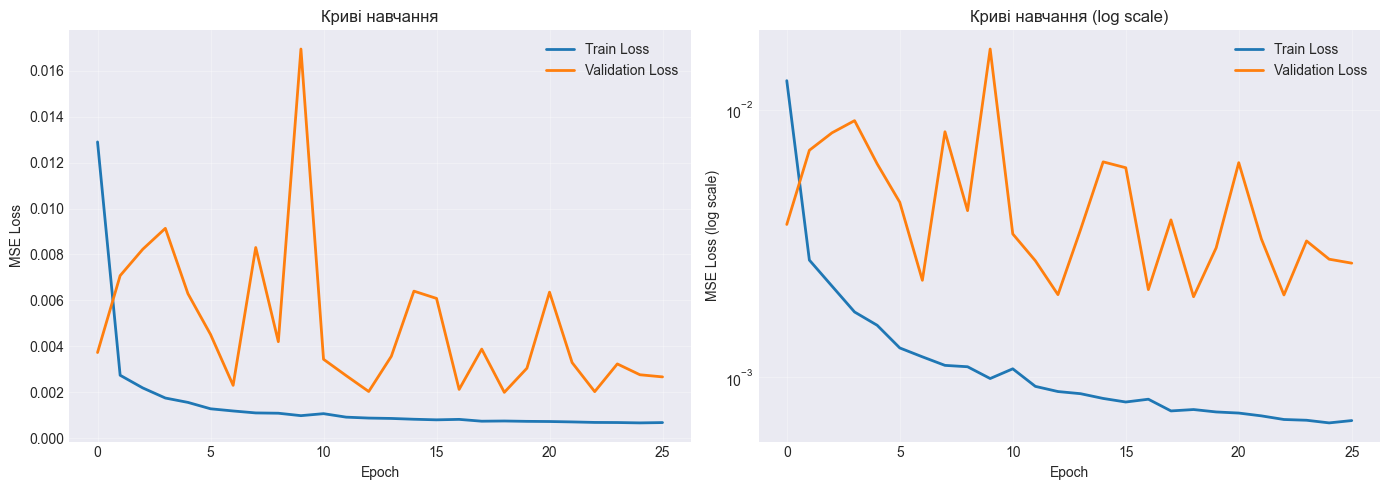

In [18]:
# Візуалізація кривих навчання
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Training vs Validation Loss
ax1 = axes[0]
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE Loss')
ax1.set_title('Криві навчання')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Log scale
ax2 = axes[1]
ax2.semilogy(train_losses, label='Train Loss', linewidth=2)
ax2.semilogy(val_losses, label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MSE Loss (log scale)')
ax2.set_title('Криві навчання (log scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

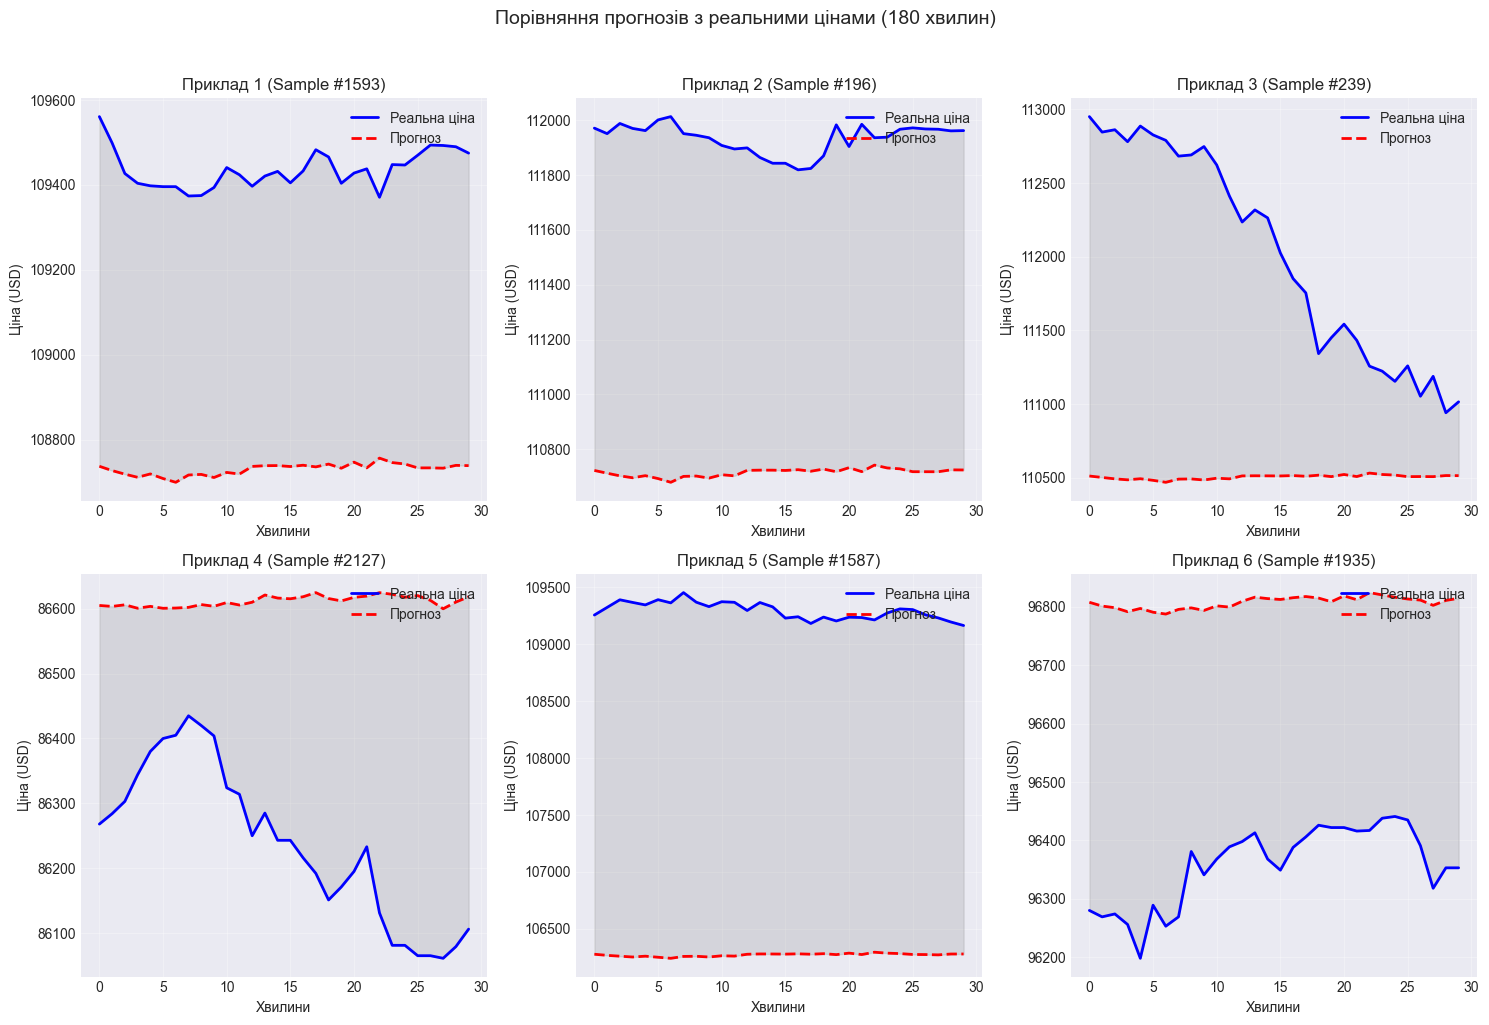

In [19]:
# Візуалізація прикладів прогнозів
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Вибираємо 6 випадкових прикладів
np.random.seed(42)
sample_indices = np.random.choice(len(predictions), 6, replace=False)

for i, idx in enumerate(sample_indices):
    ax = axes[i]
    time_points = np.arange(OUTPUT_WINDOW)
    
    ax.plot(time_points, actuals[idx], label='Реальна ціна', linewidth=2, color='blue')
    ax.plot(time_points, predictions[idx], label='Прогноз', linewidth=2, color='red', linestyle='--')
    
    # Заповнення області між прогнозом і реальністю
    ax.fill_between(time_points, actuals[idx], predictions[idx], alpha=0.2, color='gray')
    
    ax.set_xlabel('Хвилини')
    ax.set_ylabel('Ціна (USD)')
    ax.set_title(f'Приклад {i+1} (Sample #{idx})')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Порівняння прогнозів з реальними цінами (180 хвилин)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

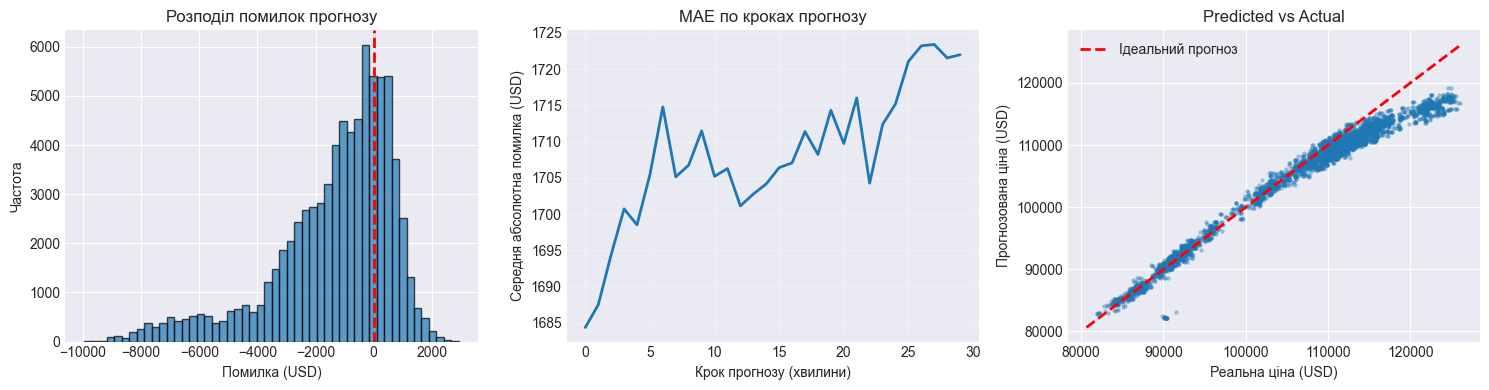


📈 Помилка зростає з 1684.34$ (1 хв) до 1721.99$ (180 хв)


In [20]:
# Аналіз помилок
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Розподіл помилок
errors = predictions.flatten() - actuals.flatten()
ax1 = axes[0]
ax1.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Помилка (USD)')
ax1.set_ylabel('Частота')
ax1.set_title('Розподіл помилок прогнозу')

# 2. Помилка по часових точках (чи зростає помилка з часом?)
mean_errors_by_step = np.abs(predictions - actuals).mean(axis=0)
ax2 = axes[1]
ax2.plot(range(OUTPUT_WINDOW), mean_errors_by_step, linewidth=2)
ax2.set_xlabel('Крок прогнозу (хвилини)')
ax2.set_ylabel('Середня абсолютна помилка (USD)')
ax2.set_title('MAE по кроках прогнозу')
ax2.grid(True, alpha=0.3)

# 3. Scatter plot: predicted vs actual
ax3 = axes[2]
sample_size = min(5000, len(actuals.flatten()))
sample_idx = np.random.choice(len(actuals.flatten()), sample_size, replace=False)
ax3.scatter(actuals.flatten()[sample_idx], predictions.flatten()[sample_idx], alpha=0.3, s=5)
min_val, max_val = actuals.min(), actuals.max()
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ідеальний прогноз')
ax3.set_xlabel('Реальна ціна (USD)')
ax3.set_ylabel('Прогнозована ціна (USD)')
ax3.set_title('Predicted vs Actual')
ax3.legend()

plt.tight_layout()
plt.show()

print(f"\n📈 Помилка зростає з {mean_errors_by_step[0]:.2f}$ (1 хв) до {mean_errors_by_step[-1]:.2f}$ (180 хв)")

In [21]:
# Збереження моделі
torch.save({
    'model_state_dict': model.state_dict(),
    'feature_scaler': feature_scaler,
    'target_scaler': target_scaler,
    'feature_columns': FEATURE_COLUMNS,
    'input_window': INPUT_WINDOW,
    'output_window': OUTPUT_WINDOW,
    'metrics': metrics
}, 'bitcoin_lstm_model.pth')

print("✅ Модель збережено у файл 'bitcoin_lstm_model.pth'")

✅ Модель збережено у файл 'bitcoin_lstm_model.pth'


## 📝 Висновки та рекомендації

### Результати:
- Модель LSTM успішно навчена прогнозувати ціну Bitcoin на 180 хвилин вперед
- Використано MPS (Apple Metal) для GPU прискорення на M4

### Можливі покращення:
1. **Більше даних**: Додати дані з Binance, on-chain метрики (hashrate, активні адреси)
2. **Альтернативні архітектури**: Transformer, Temporal Fusion Transformer (TFT)
3. **Ensemble**: Комбінувати кілька моделей
4. **Feature selection**: Використати SHAP для аналізу важливості фіч
5. **Hyperparameter tuning**: Optuna для оптимізації гіперпараметрів

### Важливо:
⚠️ **Disclaimer**: Ця модель призначена для навчальних цілей. Фінансові ринки є непередбачуваними, і минула продуктивність не гарантує майбутніх результатів. Не використовуйте цю модель для реальних торгових рішень без додаткового аналізу ризиків.